In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
import torch as th
import torch.nn as nn
import dgl
from dgl import function as fn
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from dgl import DGLGraph
import torch.nn.functional as F
from torch.autograd import Variable
import time
import seaborn

## 实验准备

In [5]:
class TAGConv(nn.Module):
    def __init__(self,
                 in_feats,    
                 out_feats,   
                 k=2,         
                 bias=True,   
                 activation=None): 
        super(TAGConv, self).__init__()   
        self._in_feats = in_feats  
        self._out_feats = out_feats 
        self._k = k
        self._activation = activation
        self.lin = nn.Linear(in_feats * (self._k + 1), out_feats, bias=bias) 

        self.reset_parameters() 


    def reset_parameters(self):      
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')     
        nn.init.xavier_normal_(self.lin.weight, gain=gain)   

        
    def forward(self, graph, feat):    
        graph = graph.local_var()           
        
        norm = th.pow(graph.in_degrees().float().clamp(min=1), -0.5) 
    
        
        shp = norm.shape + (1,) * (feat.dim() - 1)    
        
        norm = th.reshape(norm, shp).to(feat.device)  

        #D-1/2 A D -1/2 X
        fstack = [feat]      
        for _ in range(self._k):

            rst = fstack[-1] * norm    
            
            graph.ndata['h'] = rst     

            graph.update_all(fn.copy_src(src='h', out='m'),   
                             fn.sum(msg='m', out='h'))     
           
            
            rst = graph.ndata['h']     
            rst = rst * norm           
            fstack.append(rst)         

        rst = self.lin(th.cat(fstack, dim=-1))    

        if self._activation is not None:
            rst = self._activation(rst)             

        return rst

In [6]:
class GCN(nn.Module):
   
    def __init__(self,input_dim,hidden_size,num_classes):
        super(GCN, self).__init__()
        self.gcn1 = TAGConv(input_dim,hidden_size,k=1)
        self.gcn2 = TAGConv(hidden_size, num_classes,k=1)
        #self.linear = nn.Linear(hidden_size, num_classes)
        #self.dropout = nn.Dropout(0.5)
        
    def forward(self, graph, feature):
        h = F.relu(self.gcn1(graph, feature))    #隐藏层运算
        h = self.gcn2(graph, h)           #全连接层运算
        return h

In [7]:
A_city=pd.read_excel('Gacross_ADJ.xlsx',index_col=[0])
A_city.fillna(value=0,inplace=True)
A_city

,武汉市,孝感市,黄冈市,荆州市,鄂州市,随州市,襄阳市,黄石市,宜昌市,荆门市,...,白城市,临沧市,拉萨市,阿坝藏族羌族自治州,阿克苏地区,营口市,琼中黎族苗族自治县,伊春市,兴安盟,金昌市
武汉市,0,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
孝感市,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
黄冈市,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
荆州市,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
鄂州市,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
营口市,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
琼中黎族苗族自治县,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
伊春市,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
兴安盟,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
A_plane = pd.read_csv('plane_312.csv',index_col=[0])
A_plane.fillna(value=0,inplace=True)
A_plane

,武汉市,孝感市,黄冈市,荆州市,鄂州市,随州市,襄阳市,黄石市,宜昌市,荆门市,...,白城市,临沧市,拉萨市,阿坝藏族羌族自治州,阿克苏地区,营口市,琼中黎族苗族自治县,伊春市,兴安盟,金昌市
武汉市,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
孝感市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
黄冈市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
荆州市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
鄂州市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
营口市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
琼中黎族苗族自治县,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
伊春市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
兴安盟,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
A_train = pd.read_csv('train_312.csv',index_col=[0])
A_train.fillna(value=0,inplace=True)
A_train

,武汉市,孝感市,黄冈市,荆州市,鄂州市,随州市,襄阳市,黄石市,宜昌市,荆门市,...,白城市,临沧市,拉萨市,阿坝藏族羌族自治州,阿克苏地区,营口市,琼中黎族苗族自治县,伊春市,兴安盟,金昌市
武汉市,1,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
孝感市,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
黄冈市,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
荆州市,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
鄂州市,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
营口市,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
琼中黎族苗族自治县,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
伊春市,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
兴安盟,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
A_pltr =  pd.read_csv('plane_train_312.csv',index_col=[0])
A_pltr.fillna(value=0,inplace=True)
A_pltr

,武汉市,孝感市,黄冈市,荆州市,鄂州市,随州市,襄阳市,黄石市,宜昌市,荆门市,...,白城市,临沧市,拉萨市,阿坝藏族羌族自治州,阿克苏地区,营口市,琼中黎族苗族自治县,伊春市,兴安盟,金昌市
武汉市,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
孝感市,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
黄冈市,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
荆州市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
鄂州市,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
营口市,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
琼中黎族苗族自治县,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
伊春市,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
兴安盟,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
for i in A_city.columns:
    for j in A_city.index:
        if i==j:
            A_city[i][j]=1

In [12]:
for i in A_plane.columns:
    for j in A_plane.index:
        if i==j:
            A_plane[i][j]=1

In [13]:
for i in A_train.columns:
    for j in A_train.index:
        if i==j:
            A_train[i][j]=1

In [14]:
for i in A_pltr.columns:
    for j in A_pltr.index:
        if i==j:
            A_pltr[i][j]=1

In [15]:
A_plane_array=np.array(A_plane)
GA=dgl.DGLGraph()
GA.add_nodes(327)
for i in range(len(A_plane_array)):
    for j in range(len(A_plane_array)):
        if A_plane_array[i][j]==1:
            GA.add_edge(i, j)
        else:
            pass
GA

DGLGraph(num_nodes=327, num_edges=5533,
         ndata_schemes={}
         edata_schemes={})

In [16]:
A_train_array=np.array(A_train)
GE = dgl.DGLGraph()
GE.add_nodes(327) 
for i in range(len(A_train_array)):
    for j in range(len(A_train_array)):
        if A_train_array[i][j]==1:
            GE.add_edge(i, j)
        else:
            pass
GE

DGLGraph(num_nodes=327, num_edges=6633,
         ndata_schemes={}
         edata_schemes={})

In [17]:
A_city_array=np.array(A_city)
G1 = dgl.DGLGraph()
G1.add_nodes(327) 
for i in range(len(A_city_array)):
    for j in range(len(A_city_array)):
        if A_city_array[i][j]==1:
            G1.add_edge(i, j)
        else:
            pass
G1

DGLGraph(num_nodes=327, num_edges=1909,
         ndata_schemes={}
         edata_schemes={})

In [18]:
A_pltr_array=np.array(A_pltr)
Gpltr = dgl.DGLGraph()
Gpltr.add_nodes(327) 
for i in range(len(A_pltr_array)):
    for j in range(len(A_pltr_array)):
        if A_pltr_array[i][j]==1:
            Gpltr.add_edge(i, j)
        else:
            pass
Gpltr

DGLGraph(num_nodes=327, num_edges=10523,
         ndata_schemes={}
         edata_schemes={})

In [19]:
df = pd.read_excel('ncov_confirmed_city_array_20200311.xlsx',index_col=[0])
df.fillna(value=0,inplace=True)

In [20]:
def gen_lab(dataset, start, end, experience, future):   
    data = []
    labels = []
    data_list = []
    labels_list = []

    real_start = start + experience     

    for i in range(real_start, end):    
        data.append(dataset.iloc[i-experience:i])    
        labels.append(dataset.iloc[i:i+future])    
    
    for j in range(len(data)):
        data_tensor = th.Tensor(np.array(data[j].T))
        data_list.append(data_tensor)
    
    for k in range(len(labels)):
        labels_tensor = th.Tensor(np.array(labels[k].T))
        labels_list.append(labels_tensor)
    
    return th.stack(data_list), th.stack(labels_list)

In [21]:
df_n = (df-df.min())/(df.max()-df.min())
train_x,train_y = gen_lab(df_n,0,30,7,1)
valid_x,valid_y = gen_lab(df_n,30,40,7,1)
test_x,test_y = gen_lab(df_n,40,50,7,1)

In [22]:
train_x.shape,train_y.shape,valid_x.shape,test_x.shape

(torch.Size([23, 327, 7]),
 torch.Size([23, 327, 1]),
 torch.Size([3, 327, 7]),
 torch.Size([3, 327, 7]))

In [23]:
def gcn_trainer(network,graph,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(graph,input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 50 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Test_Loss {:.4f}".format(epoch+1, loss.item())) 

In [25]:
GPGCN=GCN(7,14,1);GPGCN_Loss_list=[];GPGCN_Loss_list.clear();GPGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(GPGCN,G1,train_x[i],train_y[i],50,th.optim.Adam(GPGCN.parameters(), lr=1e-3),nn.L1Loss(),GPGCN_Loss_list,GPGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.1565
Batch2: Epoch 0050 | MAE_Test_Loss 0.1107
Batch3: Epoch 0050 | MAE_Test_Loss 0.1030
Batch4: Epoch 0050 | MAE_Test_Loss 0.0915
Batch5: Epoch 0050 | MAE_Test_Loss 0.0706
Batch6: Epoch 0050 | MAE_Test_Loss 0.0627
Batch7: Epoch 0050 | MAE_Test_Loss 0.0660
Batch8: Epoch 0050 | MAE_Test_Loss 0.0604
Batch9: Epoch 0050 | MAE_Test_Loss 0.0562
Batch10: Epoch 0050 | MAE_Test_Loss 0.0559
Batch11: Epoch 0050 | MAE_Test_Loss 0.0302
Batch12: Epoch 0050 | MAE_Test_Loss 0.0464
Batch13: Epoch 0050 | MAE_Test_Loss 0.0435
Batch14: Epoch 0050 | MAE_Test_Loss 0.0368
Batch15: Epoch 0050 | MAE_Test_Loss 0.0322
Batch16: Epoch 0050 | MAE_Test_Loss 0.0283
Batch17: Epoch 0050 | MAE_Test_Loss 0.0264
Batch18: Epoch 0050 | MAE_Test_Loss 0.0269
Batch19: Epoch 0050 | MAE_Test_Loss 0.0239
Batch20: Epoch 0050 | MAE_Test_Loss 0.0159
Batch21: Epoch 0050 | MAE_Test_Loss 0.0163
Batch22: Epoch 0050 | MAE_Test_Loss 0.0128
Batch23: Epoch 0050 | MAE_Test_Loss 0.0100


In [26]:
HSRGCN=GCN(7,14,1);HSRGCN_Loss_list=[];HSRGCN_Loss_list.clear();HSRGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(HSRGCN,GA,train_x[i],train_y[i],50,th.optim.Adam(HSRGCN.parameters(), lr=1e-3),nn.L1Loss(),HSRGCN_Loss_list,HSRGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0902
Batch2: Epoch 0050 | MAE_Test_Loss 0.0648
Batch3: Epoch 0050 | MAE_Test_Loss 0.0617
Batch4: Epoch 0050 | MAE_Test_Loss 0.0544
Batch5: Epoch 0050 | MAE_Test_Loss 0.0467
Batch6: Epoch 0050 | MAE_Test_Loss 0.0556
Batch7: Epoch 0050 | MAE_Test_Loss 0.0572
Batch8: Epoch 0050 | MAE_Test_Loss 0.0489
Batch9: Epoch 0050 | MAE_Test_Loss 0.0518
Batch10: Epoch 0050 | MAE_Test_Loss 0.0500
Batch11: Epoch 0050 | MAE_Test_Loss 0.0217
Batch12: Epoch 0050 | MAE_Test_Loss 0.0423
Batch13: Epoch 0050 | MAE_Test_Loss 0.0375
Batch14: Epoch 0050 | MAE_Test_Loss 0.0319
Batch15: Epoch 0050 | MAE_Test_Loss 0.0267
Batch16: Epoch 0050 | MAE_Test_Loss 0.0241
Batch17: Epoch 0050 | MAE_Test_Loss 0.0231
Batch18: Epoch 0050 | MAE_Test_Loss 0.0223
Batch19: Epoch 0050 | MAE_Test_Loss 0.0191
Batch20: Epoch 0050 | MAE_Test_Loss 0.0133
Batch21: Epoch 0050 | MAE_Test_Loss 0.0125
Batch22: Epoch 0050 | MAE_Test_Loss 0.0120
Batch23: Epoch 0050 | MAE_Test_Loss 0.0079


In [27]:
ALGCN=GCN(7,14,1);ALGCN_Loss_list=[];ALGCN_Loss_list.clear();ALGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(ALGCN,GE,train_x[i],train_y[i],50,th.optim.Adam(ALGCN.parameters(), lr=1e-3),nn.L1Loss(),ALGCN_Loss_list,ALGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.1253
Batch2: Epoch 0050 | MAE_Test_Loss 0.0839
Batch3: Epoch 0050 | MAE_Test_Loss 0.0700
Batch4: Epoch 0050 | MAE_Test_Loss 0.0635
Batch5: Epoch 0050 | MAE_Test_Loss 0.0537
Batch6: Epoch 0050 | MAE_Test_Loss 0.0559
Batch7: Epoch 0050 | MAE_Test_Loss 0.0591
Batch8: Epoch 0050 | MAE_Test_Loss 0.0513
Batch9: Epoch 0050 | MAE_Test_Loss 0.0558
Batch10: Epoch 0050 | MAE_Test_Loss 0.0514
Batch11: Epoch 0050 | MAE_Test_Loss 0.0226
Batch12: Epoch 0050 | MAE_Test_Loss 0.0438
Batch13: Epoch 0050 | MAE_Test_Loss 0.0412
Batch14: Epoch 0050 | MAE_Test_Loss 0.0339
Batch15: Epoch 0050 | MAE_Test_Loss 0.0267
Batch16: Epoch 0050 | MAE_Test_Loss 0.0259
Batch17: Epoch 0050 | MAE_Test_Loss 0.0243
Batch18: Epoch 0050 | MAE_Test_Loss 0.0232
Batch19: Epoch 0050 | MAE_Test_Loss 0.0200
Batch20: Epoch 0050 | MAE_Test_Loss 0.0145
Batch21: Epoch 0050 | MAE_Test_Loss 0.0140
Batch22: Epoch 0050 | MAE_Test_Loss 0.0116
Batch23: Epoch 0050 | MAE_Test_Loss 0.0124


In [28]:
ALHSRGCN=GCN(7,14,1);ALHSRGCN_Loss_list=[];ALHSRGCN_Loss_list.clear();ALHSRGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(ALHSRGCN,Gpltr,train_x[i],train_y[i],50,th.optim.Adam(ALHSRGCN.parameters(), lr=1e-3),nn.L1Loss(),ALHSRGCN_Loss_list,ALHSRGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0998
Batch2: Epoch 0050 | MAE_Test_Loss 0.0684
Batch3: Epoch 0050 | MAE_Test_Loss 0.0669
Batch4: Epoch 0050 | MAE_Test_Loss 0.0603
Batch5: Epoch 0050 | MAE_Test_Loss 0.0528
Batch6: Epoch 0050 | MAE_Test_Loss 0.0574
Batch7: Epoch 0050 | MAE_Test_Loss 0.0598
Batch8: Epoch 0050 | MAE_Test_Loss 0.0526
Batch9: Epoch 0050 | MAE_Test_Loss 0.0513
Batch10: Epoch 0050 | MAE_Test_Loss 0.0513
Batch11: Epoch 0050 | MAE_Test_Loss 0.0247
Batch12: Epoch 0050 | MAE_Test_Loss 0.0401
Batch13: Epoch 0050 | MAE_Test_Loss 0.0380
Batch14: Epoch 0050 | MAE_Test_Loss 0.0321
Batch15: Epoch 0050 | MAE_Test_Loss 0.0272
Batch16: Epoch 0050 | MAE_Test_Loss 0.0261
Batch17: Epoch 0050 | MAE_Test_Loss 0.0237
Batch18: Epoch 0050 | MAE_Test_Loss 0.0242
Batch19: Epoch 0050 | MAE_Test_Loss 0.0202
Batch20: Epoch 0050 | MAE_Test_Loss 0.0147
Batch21: Epoch 0050 | MAE_Test_Loss 0.0148
Batch22: Epoch 0050 | MAE_Test_Loss 0.0114
Batch23: Epoch 0050 | MAE_Test_Loss 0.0088


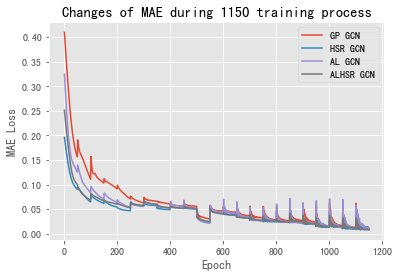

In [29]:
plt.style.use('ggplot')
plt.plot(GPGCN_Loss_list,label='GP GCN')
plt.plot(HSRGCN_Loss_list,label='HSR GCN')
plt.plot(ALGCN_Loss_list,label='AL GCN')
plt.plot(ALHSRGCN_Loss_list,label='ALHSR GCN')
plt.title('Changes of MAE during 1150 training process')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(loc=1)
plt.show()

In [30]:
GPGCN_During=np.sum(GPGCN_MAE_Dur_list)
HSRGCN_During=np.sum(HSRGCN_MAE_Dur_list)
ALGCN_During=np.sum(ALGCN_MAE_Dur_list)
ALHSRGCN_During=np.sum(ALHSRGCN_MAE_Dur_list)

In [31]:
GPGCN_During,HSRGCN_During,ALGCN_During,ALHSRGCN_During

(1.8715715408325195, 2.057973623275757, 2.1094841957092285, 2.3319594860076904)

In [32]:
def mean_losslist(tlist):
    return np.sum(tlist)/len(tlist)

In [33]:
mean_losslist(GPGCN_Loss_list),mean_losslist(HSRGCN_Loss_list),mean_losslist(ALGCN_Loss_list),mean_losslist(ALHSRGCN_Loss_list)

(tensor(0.0611, grad_fn=<DivBackward0>),
 tensor(0.0425, grad_fn=<DivBackward0>),
 tensor(0.0500, grad_fn=<DivBackward0>),
 tensor(0.0451, grad_fn=<DivBackward0>))

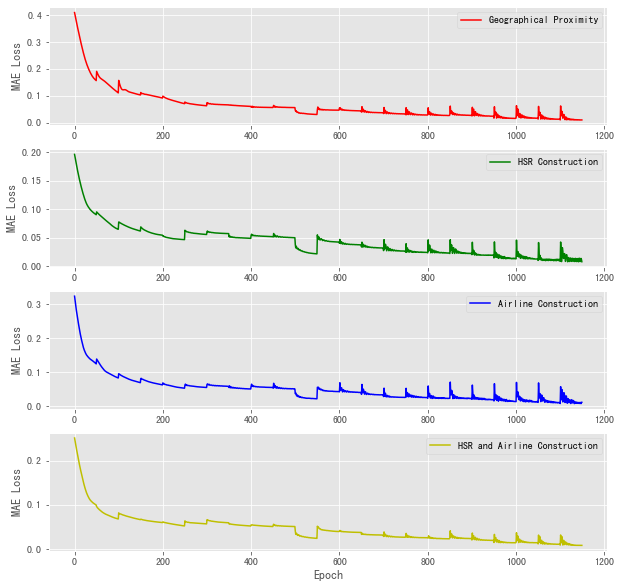

In [34]:
plt.figure(figsize=(10,10))
plt.figure(1)
ax1 = plt.subplot(411)
plt.plot(GPGCN_Loss_list,color='r',linestyle = "-",label='Geographical Proximity')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax2 = plt.subplot(412)
plt.plot(HSRGCN_Loss_list,color='g',linestyle = "-",label='HSR Construction')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax3 = plt.subplot(413)
plt.plot(ALGCN_Loss_list,color='b',linestyle = "-",label='Airline Construction')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax4= plt.subplot(414)
plt.plot(ALHSRGCN_Loss_list,color='y',linestyle = "-",label='HSR and Airline Construction')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
plt.xlabel('Epoch')
plt.show()

In [35]:
def gcn_valid(network,test_input,test_label,criterion,loss_list):
    for i in range(len(test_input)):
        loss = criterion(network(G1,test_input[i]),test_label[i])
        loss_list.append(loss)

In [37]:
GPGCN_valid_loss_list=[];GPGCN_valid_loss_list.clear()
gcn_valid(GPGCN,valid_x,valid_y,nn.L1Loss(),GPGCN_valid_loss_list)

In [39]:
HSRGCN_valid_loss_list=[];HSRGCN_valid_loss_list.clear()
gcn_valid(HSRGCN,valid_x,valid_y,nn.L1Loss(),HSRGCN_valid_loss_list)

In [40]:
ALGCN_valid_loss_list=[];ALGCN_valid_loss_list.clear()
gcn_valid(ALGCN,valid_x,valid_y,nn.L1Loss(),ALGCN_valid_loss_list)

In [41]:
ALHSRGCN_valid_loss_list=[];ALHSRGCN_valid_loss_list.clear()
gcn_valid(ALHSRGCN,valid_x,valid_y,nn.L1Loss(),ALHSRGCN_valid_loss_list)

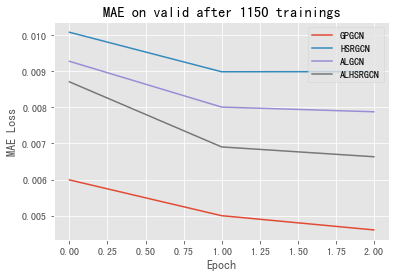

In [43]:
plt.plot(GPGCN_valid_loss_list,label='GPGCN')
plt.plot(HSRGCN_valid_loss_list,label='HSRGCN')
plt.plot(ALGCN_valid_loss_list,label='ALGCN')
plt.plot(ALHSRGCN_valid_loss_list,label='ALHSRGCN')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE on valid after 1150 trainings')
plt.legend(loc=1)

In [44]:
def gcn_tester(network,test_input,test_label,criterion,loss_list):
    for i in range(len(test_input)):
        loss = criterion(network(G1,test_input[i]),test_label[i])
        loss_list.append(loss)

In [46]:
GPGCN_test_loss_list=[];GPGCN_test_loss_list.clear()
gcn_tester(GPGCN,test_x,test_y,nn.L1Loss(),GPGCN_test_loss_list)

In [47]:
HSRGCN_test_loss_list=[];HSRGCN_test_loss_list.clear()
gcn_tester(HSRGCN,test_x,test_y,nn.L1Loss(),HSRGCN_test_loss_list)

In [48]:
ALGCN_test_loss_list=[];ALGCN_test_loss_list.clear()
gcn_tester(ALGCN,test_x,test_y,nn.L1Loss(),ALGCN_test_loss_list)

In [49]:
ALHSRGCN_test_loss_list=[];ALHSRGCN_test_loss_list.clear()
gcn_tester(ALHSRGCN,test_x,test_y,nn.L1Loss(),ALHSRGCN_test_loss_list)

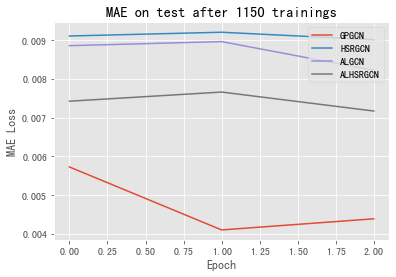

In [51]:
plt.plot(GPGCN_test_loss_list,label='GPGCN')
plt.plot(HSRGCN_test_loss_list,label='HSRGCN')
plt.plot(ALGCN_test_loss_list,label='ALGCN')
plt.plot(ALHSRGCN_test_loss_list,label='ALHSRGCN')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE on test after 1150 trainings')
plt.legend(loc=1)

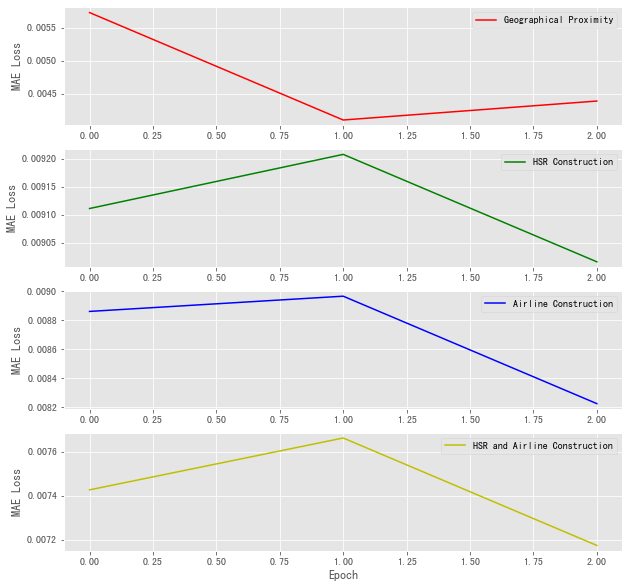

In [52]:
plt.figure(figsize=(10,10))
plt.figure(1)

ax1 = plt.subplot(411)
plt.plot(GPGCN_test_loss_list,color="r",linestyle = "-",label='Geographical Proximity')
plt.ylabel('MAE Loss')
plt.legend()

ax2 = plt.subplot(412)
plt.plot(HSRGCN_test_loss_list, color="g",linestyle = "-",label='HSR Construction')
plt.ylabel('MAE Loss')
plt.legend()

ax3 = plt.subplot(413)
plt.plot(ALGCN_test_loss_list,color="b",linestyle = "-",label='Airline Construction')
plt.ylabel('MAE Loss')
plt.legend()

ax4 = plt.subplot(414)
plt.plot(ALHSRGCN_test_loss_list,color="y",linestyle = "-",label='HSR and Airline Construction')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()

In [53]:
mean_losslist(GPGCN_test_loss_list),mean_losslist(HSRGCN_test_loss_list)

(tensor(0.0047, grad_fn=<DivBackward0>),
 tensor(0.0091, grad_fn=<DivBackward0>))

In [54]:
mean_losslist(ALGCN_test_loss_list),mean_losslist(ALHSRGCN_test_loss_list)

(tensor(0.0087, grad_fn=<DivBackward0>),
 tensor(0.0074, grad_fn=<DivBackward0>))

## RNN

In [55]:
class RNNs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(RNNs,self).__init__()

        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.rnn(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [56]:
def rnn_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [58]:
RNN_Model = RNNs(7, 14, 1,2);RNN_Loss_list=[];RNN_Loss_list.clear();RNN_Dur_list=[]
rnn_trainer(RNN_Model,train_x,train_y,1150,th.optim.Adam(RNN_Model.parameters(), lr=1e-3),nn.L1Loss(),RNN_Loss_list,RNN_Dur_list)

Epoch 0100 | MAE_Loss 0.0791
Epoch 0200 | MAE_Loss 0.0622
Epoch 0300 | MAE_Loss 0.0521
Epoch 0400 | MAE_Loss 0.0467
Epoch 0500 | MAE_Loss 0.0437
Epoch 0600 | MAE_Loss 0.0409
Epoch 0700 | MAE_Loss 0.0392
Epoch 0800 | MAE_Loss 0.0372
Epoch 0900 | MAE_Loss 0.0361
Epoch 1000 | MAE_Loss 0.0355
Epoch 1100 | MAE_Loss 0.0352


No handles with labels found to put in legend.


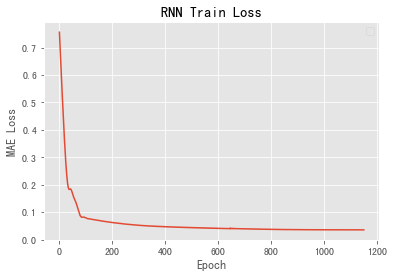

In [60]:
plt.style.use('ggplot')
plt.plot(RNN_Loss_list)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('RNN Train Loss')
plt.legend()

In [59]:
mean_losslist(RNN_Loss_list)

tensor(0.0605, grad_fn=<DivBackward0>)

In [61]:
def rnn_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [63]:
RNN_test_loss_list=[];RNN_test_loss_list.clear()
rnn_tester(RNN_Model,test_x,test_y,nn.L1Loss(),RNN_test_loss_list)

In [64]:
mean_losslist(RNN_test_loss_list)

tensor(0.1791, grad_fn=<DivBackward0>)

## LSTM

In [65]:
class LSTMs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(LSTMs,self).__init__()

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.lstm(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [66]:
LSTM_Model=LSTMs(7,14,1,2)

In [67]:
def lstm_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [69]:
LSTM_Loss_list=[];LSTM_Loss_list.clear();LSTM_Dur_list=[]
lstm_trainer(LSTM_Model,train_x,train_y,1150,th.optim.Adam(LSTM_Model.parameters(), lr=1e-3),nn.L1Loss(),LSTM_Loss_list,LSTM_Dur_list)

Epoch 0100 | MAE_Loss 0.1014
Epoch 0200 | MAE_Loss 0.0917
Epoch 0300 | MAE_Loss 0.0783
Epoch 0400 | MAE_Loss 0.0669
Epoch 0500 | MAE_Loss 0.0592
Epoch 0600 | MAE_Loss 0.0519
Epoch 0700 | MAE_Loss 0.0456
Epoch 0800 | MAE_Loss 0.0414
Epoch 0900 | MAE_Loss 0.0382
Epoch 1000 | MAE_Loss 0.0367
Epoch 1100 | MAE_Loss 0.0357


No handles with labels found to put in legend.


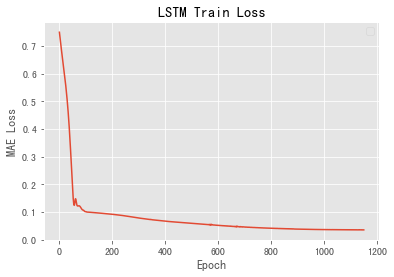

In [70]:
plt.style.use('ggplot')
plt.plot(LSTM_Loss_list)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('LSTM Train Loss')
plt.legend()

In [71]:
mean_losslist(LSTM_Loss_list)

tensor(0.0798, grad_fn=<DivBackward0>)

In [72]:
def lstm_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [74]:
LSTM_test_loss_list=[];LSTM_test_loss_list.clear()
lstm_tester(LSTM_Model,test_x,test_y,nn.L1Loss(),LSTM_test_loss_list)

In [75]:
mean_losslist(LSTM_test_loss_list)

tensor(0.0866, grad_fn=<DivBackward0>)

## GRU

In [76]:
class GRUs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(GRUs,self).__init__()

        self.lstm = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.lstm(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [77]:
GRU_Model=GRUs(7,14,1,2)

In [78]:
def gru_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [80]:
GRU_Loss_list=[];GRU_Loss_list.clear();GRU_Dur_list=[]
gru_trainer(GRU_Model,train_x,train_y,1150,th.optim.Adam(GRU_Model.parameters(), lr=1e-3),nn.L1Loss(),GRU_Loss_list,GRU_Dur_list)

Epoch 0100 | MAE_Loss 0.0858
Epoch 0200 | MAE_Loss 0.0702
Epoch 0300 | MAE_Loss 0.0590
Epoch 0400 | MAE_Loss 0.0500
Epoch 0500 | MAE_Loss 0.0440
Epoch 0600 | MAE_Loss 0.0406
Epoch 0700 | MAE_Loss 0.0384
Epoch 0800 | MAE_Loss 0.0368
Epoch 0900 | MAE_Loss 0.0358
Epoch 1000 | MAE_Loss 0.0351
Epoch 1100 | MAE_Loss 0.0348


No handles with labels found to put in legend.


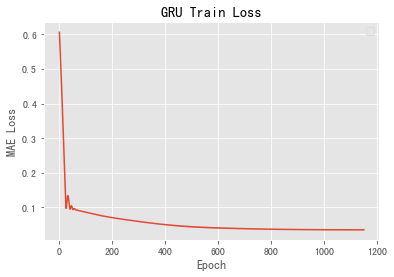

In [81]:
plt.style.use('ggplot')
plt.plot(GRU_Loss_list)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('GRU Train Loss')
plt.legend()

In [82]:
mean_losslist(GRU_Loss_list)

tensor(0.0564, grad_fn=<DivBackward0>)

In [83]:
def gru_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [86]:
GRU_test_loss_list=[];GRU_test_loss_list.clear()
gru_tester(GRU_Model,test_x,test_y,nn.L1Loss(),GRU_test_loss_list)

In [87]:
mean_losslist(GRU_test_loss_list)

tensor(0.0898, grad_fn=<DivBackward0>)

## 综合分析

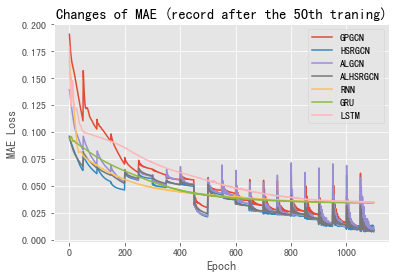

In [88]:
plt.style.use('ggplot')
plt.plot(GPGCN_Loss_list[50:],label='GPGCN')
plt.plot(HSRGCN_Loss_list[50:],label='HSRGCN')
plt.plot(ALGCN_Loss_list[50:],label='ALGCN')
plt.plot(ALHSRGCN_Loss_list[50:],label='ALHSRGCN')
plt.plot(RNN_Loss_list[50:],label='RNN')
plt.plot(GRU_Loss_list[50:],label='GRU')
plt.plot(LSTM_Loss_list[50:],label='LSTM')

plt.title('Changes of MAE (record after the 50th traning)')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(loc=1)
plt.show()

In [89]:
GPGCN_test_loss_list

([tensor(0.0057, grad_fn=<L1LossBackward>),
  tensor(0.0041, grad_fn=<L1LossBackward>),
  tensor(0.0044, grad_fn=<L1LossBackward>)],
 [tensor(0.0866, grad_fn=<L1LossBackward>),
  tensor(0.0866, grad_fn=<L1LossBackward>),
  tensor(0.0866, grad_fn=<L1LossBackward>)])

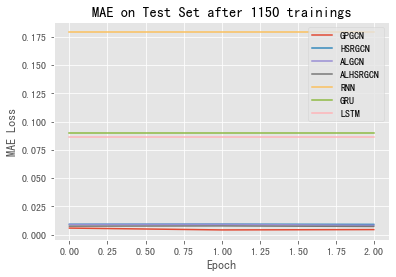

In [90]:
plt.plot(GPGCN_test_loss_list,label='GPGCN')
plt.plot(HSRGCN_test_loss_list,label='HSRGCN')
plt.plot(ALGCN_test_loss_list,label='ALGCN')
plt.plot(ALHSRGCN_test_loss_list,label='ALHSRGCN')
plt.plot(RNN_test_loss_list,label='RNN')
plt.plot(GRU_test_loss_list,label='GRU')
plt.plot(LSTM_test_loss_list,label='LSTM')

plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
#plt.ylim(0.000,0.4)
plt.title('MAE on Test Set after 1150 trainings')
plt.legend()

In [91]:
RNN_During,LSTM_During,GRU_During=np.sum(RNN_Dur_list),np.sum(LSTM_Dur_list),np.sum(GRU_Dur_list)
RNN_During,LSTM_During,GRU_During

(9.129839658737183, 47.28683114051819, 33.55726408958435)

In [92]:
MAE_LIST=[mean_losslist(GPGCN_test_loss_list).item(),
 mean_losslist(HSRGCN_test_loss_list).item(),
 mean_losslist(ALGCN_test_loss_list).item(),
 mean_losslist(ALHSRGCN_test_loss_list).item(),
           mean_losslist(RNN_test_loss_list).item(),
          mean_losslist(GRU_test_loss_list).item(),
           mean_losslist(LSTM_test_loss_list).item()]
DUR_LIST=[GPGCN_During,HSRGCN_During,ALGCN_During,ALHSRGCN_During,RNN_During,GRU_During,LSTM_During]
NAME_LIST=['GP GCN','HSR GCN',"AL GCN","ALHSR GCN",'RNN','GRU','LSTM']

In [93]:
len(MAE_LIST),len(DUR_LIST),len(NAME_LIST)

(7, 7, 7)

In [94]:
MAEDUR_dict={'MAE':MAE_LIST,'DUR':DUR_LIST,'NAME':NAME_LIST}
MAEDUR=pd.DataFrame(MAEDUR_dict)
MAEDUR=MAEDUR.set_index(MAEDUR['NAME'])
MAEDUR

,MAE,DUR,NAME
NAME,,,
GP GCN,0.004740,1.871572,GP GCN
HSR GCN,0.009112,2.057974,HSR GCN
AL GCN,0.008684,2.109484,AL GCN
ALHSR GCN,0.007421,2.331959,ALHSR GCN
RNN,0.179105,9.129840,RNN
GRU,0.089779,33.557264,GRU
LSTM,0.086557,47.286831,LSTM


/Users/yangchengyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


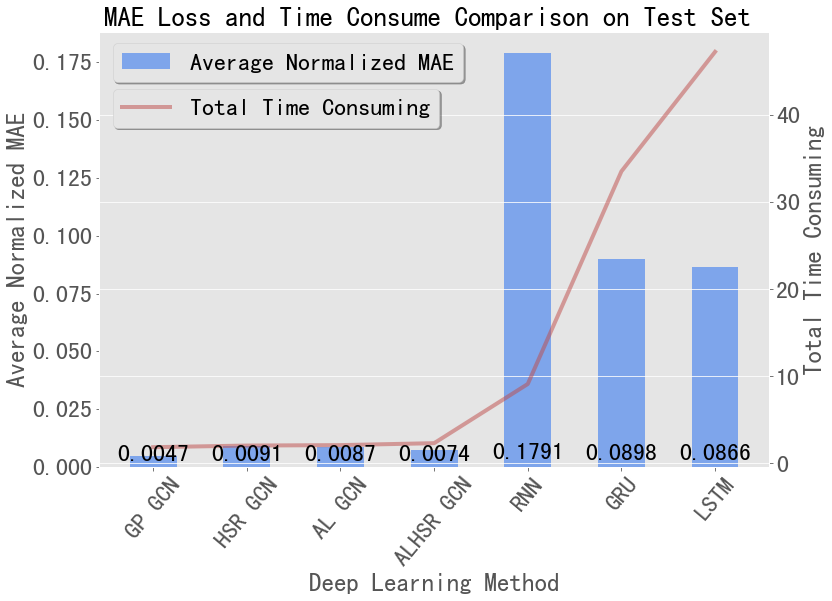

In [115]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
plt.xticks(rotation=50,fontsize=24)
plt.yticks(fontsize=24)
plt.grid(False) 
ax1=ax.twinx()

ax1.plot(MAEDUR['DUR'],color='#BE4B48',linewidth=4,label='Total Time Consuming',alpha=0.5)


ax.bar(MAEDUR['NAME'],MAEDUR['MAE'],width=0.5,label='Average Normalized MAE',color='cornflowerblue',alpha=0.8)
#ax.legend(loc='best')

plt.yticks(fontsize=24)
ax.set_xlabel(r'Deep Learning Method',fontsize=25)
ax.set_ylabel(r'Average Normalized MAE',fontsize=25)     #plt.xticks(rotation=50,fontsize=13)



ax1.set_ylabel(r'Total Time Consuming',fontsize=25)
#plt.legend(loc=2,fontsize=14)


legend1=ax.legend(loc=(.02,.885),fontsize=24,shadow=True)
legend2=ax1.legend(loc=(.02,.78),fontsize=24,shadow=True)





for a,b in zip(MAEDUR.index,MAEDUR['MAE']):
    plt.text(a, b, '%.4f' % b, ha='center', va="bottom",fontsize=24)

'''
for a,b in zip(MAEDUR.index,MAEDUR['DUR']):
    plt.text(a, b+0.5, '%.2f' % b, ha='center', va="bottom",fontsize=16)
'''


plt.title('MAE Loss and Time Consume Comparison on Test Set ',fontsize=27) 

fig.show()